In [1]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import zipfile
import os
# --- CONFIGURATION ---
DRIVE_ZIP_PATH = "/content/drive/MyDrive/dentex_project/training_data.zip"
LOCAL_DATA_DIR = "/content/temp_data"

def unzip_data(zip_path, extract_to):
    if not os.path.exists(zip_path):
        print(f"Zip file not found: {zip_path}")
        return
    print(f"Unzipping {zip_path} to {extract_to}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("Unzip complete.")

# 1. Unzip Training Data (only if not already done)
if not os.path.exists(LOCAL_DATA_DIR) or not os.listdir(LOCAL_DATA_DIR):
    os.makedirs(LOCAL_DATA_DIR, exist_ok=True)
    unzip_data(DRIVE_ZIP_PATH, LOCAL_DATA_DIR)

Unzipping /content/drive/MyDrive/dentex_project/training_data.zip to /content/temp_data...
Unzip complete.


In [4]:
"""
DENTEX Data Explorer - Run this FIRST to understand your data structure
Then we'll adapt the training pipeline accordingly
"""

import os
import json
from pathlib import Path
from collections import defaultdict

def explore_dentex_data(data_dir):
    """
    Comprehensive exploration of DENTEX data structure
    """
    print("=" * 80)
    print("DENTEX DATA STRUCTURE EXPLORER")
    print("=" * 80)

    data_path = Path(data_dir)

    # 1. LIST ALL DIRECTORIES
    print("\n📁 DIRECTORY STRUCTURE:")
    print("-" * 80)
    for root, dirs, files in os.walk(data_dir):
        level = root.replace(str(data_dir), '').count(os.sep)
        indent = ' ' * 2 * level
        print(f'{indent}{os.path.basename(root)}/')

        # Show first few files in each directory
        sub_indent = ' ' * 2 * (level + 1)
        for file in sorted(files)[:5]:  # Show first 5 files
            print(f'{sub_indent}├── {file}')
        if len(files) > 5:
            print(f'{sub_indent}└── ... and {len(files) - 5} more files')

    # 2. FIND ALL JSON FILES
    print("\n" + "=" * 80)
    print("📄 ANNOTATION FILES (JSON):")
    print("-" * 80)

    json_files = list(data_path.rglob('*.json'))

    if not json_files:
        print("⚠️  No JSON files found!")
        print("\n🔍 Looking for other annotation formats...")
        xml_files = list(data_path.rglob('*.xml'))
        txt_files = list(data_path.rglob('*.txt'))
        print(f"   Found {len(xml_files)} XML files")
        print(f"   Found {len(txt_files)} TXT files")
        return

    print(f"Found {len(json_files)} JSON file(s):\n")

    for idx, json_file in enumerate(json_files):
        print(f"\n[{idx + 1}] {json_file.relative_to(data_dir)}")
        print(f"    Size: {json_file.stat().st_size / 1024:.2f} KB")

        try:
            with open(json_file, 'r') as f:
                data = json.load(f)

            # Analyze structure
            print(f"    Keys: {list(data.keys())}")

            # COCO format detection
            if 'images' in data and 'annotations' in data and 'categories' in data:
                print(f"    ✅ COCO format detected!")
                print(f"       Images: {len(data['images'])}")
                print(f"       Annotations: {len(data['annotations'])}")
                print(f"       Categories: {len(data['categories'])}")

                # Show categories
                print(f"\n    📊 CATEGORIES:")
                for cat in data['categories']:
                    print(f"       - ID {cat['id']}: {cat['name']}")

                # Sample image info
                if data['images']:
                    sample_img = data['images'][0]
                    print(f"\n    🖼️  SAMPLE IMAGE INFO:")
                    print(f"       file_name: {sample_img.get('file_name', 'N/A')}")
                    print(f"       width: {sample_img.get('width', 'N/A')}")
                    print(f"       height: {sample_img.get('height', 'N/A')}")
                    print(f"       id: {sample_img.get('id', 'N/A')}")

                # Sample annotation
                if data['annotations']:
                    sample_anno = data['annotations'][0]
                    print(f"\n    📍 SAMPLE ANNOTATION:")
                    print(f"       image_id: {sample_anno.get('image_id', 'N/A')}")
                    print(f"       category_id: {sample_anno.get('category_id', 'N/A')}")
                    print(f"       bbox: {sample_anno.get('bbox', 'N/A')}")
                    print(f"       area: {sample_anno.get('area', 'N/A')}")

                # Count annotations per category
                category_counts = defaultdict(int)
                for anno in data['annotations']:
                    category_counts[anno['category_id']] += 1

                print(f"\n    📈 ANNOTATIONS PER CATEGORY:")
                for cat in data['categories']:
                    count = category_counts[cat['id']]
                    print(f"       {cat['name']}: {count} annotations")

            else:
                print(f"    ⚠️  Unknown format")
                if isinstance(data, dict):
                    for key, val in list(data.items())[:5]:
                        print(f"       {key}: {type(val)}")

        except Exception as e:
            print(f"    ❌ Error reading file: {e}")

    # 3. FIND IMAGE FILES
    print("\n" + "=" * 80)
    print("🖼️  IMAGE FILES:")
    print("-" * 80)

    image_extensions = ['.png', '.jpg', '.jpeg', '.dcm', '.tif', '.tiff']
    image_counts = defaultdict(int)
    image_dirs = set()

    for ext in image_extensions:
        files = list(data_path.rglob(f'*{ext}'))
        if files:
            image_counts[ext] = len(files)
            for f in files:
                image_dirs.add(f.parent)

    print(f"Total image files: {sum(image_counts.values())}")
    for ext, count in image_counts.items():
        print(f"  {ext}: {count} files")

    print(f"\nImages found in {len(image_dirs)} directories:")
    for img_dir in sorted(image_dirs):
        file_count = len(list(img_dir.glob('*.*')))
        print(f"  {img_dir.relative_to(data_dir)}/  ({file_count} files)")

    # 4. IDENTIFY DATASET TYPES
    print("\n" + "=" * 80)
    print("🎯 DATASET IDENTIFICATION:")
    print("-" * 80)

    dataset_types = {
        'quadrant': [],
        'enumeration': [],
        'diagnosis': [],
        'unlabeled': []
    }

    for json_file in json_files:
        name_lower = str(json_file).lower()
        if 'quadrant' in name_lower and 'enum' not in name_lower:
            dataset_types['quadrant'].append(json_file)
        elif 'enum' in name_lower and 'diag' not in name_lower:
            dataset_types['enumeration'].append(json_file)
        elif 'diag' in name_lower or 'diagnosis' in name_lower:
            dataset_types['diagnosis'].append(json_file)

    # Check for unlabeled data
    unlabeled_dirs = [d for d in data_path.rglob('*') if d.is_dir() and 'unlabeled' in d.name.lower()]
    if unlabeled_dirs:
        dataset_types['unlabeled'] = unlabeled_dirs

    for dtype, files in dataset_types.items():
        if files:
            print(f"\n{dtype.upper()} dataset:")
            for f in files:
                if f.is_file():
                    print(f"  ✓ {f.relative_to(data_dir)}")
                else:
                    print(f"  ✓ {f.relative_to(data_dir)}/")
        else:
            print(f"\n{dtype.upper()} dataset: ❌ Not found")

    # 5. RECOMMENDATIONS
    print("\n" + "=" * 80)
    print("💡 RECOMMENDATIONS:")
    print("-" * 80)

    quadrant_files = dataset_types['quadrant']
    if quadrant_files:
        print(f"\n✅ Found quadrant dataset! Start with:")
        print(f"   File: {quadrant_files[0].relative_to(data_dir)}")
        print(f"\n   Next step: Use this file path in the training pipeline")
    else:
        print("\n⚠️  Quadrant-only dataset not clearly identified.")
        print("   Please manually identify which JSON file contains:")
        print("   - Only 4 categories (quadrant_1, quadrant_2, quadrant_3, quadrant_4)")
        print("   - OR categories with 'quadrant' in the name")
        print("   - Typically ~693 images according to the paper")

    print("\n" + "=" * 80)

    return {
        'json_files': json_files,
        'dataset_types': dataset_types,
        'image_counts': image_counts,
        'total_images': sum(image_counts.values())
    }


# ============================================================================
# QUICK VERIFICATION FUNCTION
# ============================================================================

def verify_annotation_file(json_path):
    """
    Verify if a JSON file is the quadrant-only annotation we need
    """
    print("\n" + "=" * 80)
    print(f"VERIFYING: {json_path}")
    print("=" * 80)

    with open(json_path, 'r') as f:
        data = json.load(f)

    categories = data.get('categories', [])
    images = data.get('images', [])
    annotations = data.get('annotations', [])

    print(f"\n📊 Statistics:")
    print(f"   Images: {len(images)}")
    print(f"   Annotations: {len(annotations)}")
    print(f"   Categories: {len(categories)}")

    print(f"\n🏷️  Categories:")
    for cat in categories:
        print(f"   {cat['id']}: {cat['name']}")

    # Check if quadrant-only
    is_quadrant_only = (
        len(categories) == 4 and
        all('quadrant' in cat['name'].lower() for cat in categories)
    )

    if is_quadrant_only:
        print(f"\n✅ This appears to be QUADRANT-ONLY data!")
        print(f"   Expected images: ~693 (paper states)")
        print(f"   Actual images: {len(images)}")
        return True
    else:
        print(f"\n⚠️  This might NOT be quadrant-only data")
        print(f"   Reason: {len(categories)} categories found")
        if categories:
            print(f"   First category: {categories[0]['name']}")
        return False


# ============================================================================
# RUN EXPLORATION
# ============================================================================

if __name__ == "__main__":
    # Your data directory from the unzip
    LOCAL_DATA_DIR = "/content/temp_data"

    # Run comprehensive exploration
    results = explore_dentex_data(LOCAL_DATA_DIR)

    print("\n\n" + "=" * 80)
    print("🎯 NEXT STEPS:")
    print("=" * 80)
    print("\n1. Review the output above")
    print("2. Identify the quadrant-only annotation file")
    print("3. Run verify_annotation_file() on that file to confirm")
    print("4. Then proceed with the training pipeline")
    print("\n" + "=" * 80)

DENTEX DATA STRUCTURE EXPLORER

📁 DIRECTORY STRUCTURE:
--------------------------------------------------------------------------------
temp_data/
  training_data/
    quadrant/
      ├── train_quadrant.json
      xrays/
        ├── train_0.png
        ├── train_1.png
        ├── train_10.png
        ├── train_100.png
        ├── train_101.png
        └── ... and 688 more files
    quadrant-enumeration-disease/
      ├── train_quadrant_enumeration_disease.json
      xrays/
        ├── train_0.png
        ├── train_1.png
        ├── train_10.png
        ├── train_100.png
        ├── train_101.png
        └── ... and 700 more files
    quadrant_enumeration/
      ├── train_quadrant_enumeration.json
      xrays/
        ├── train_0.png
        ├── train_1.png
        ├── train_10.png
        ├── train_100.png
        ├── train_101.png
        └── ... and 629 more files
    unlabelled/
      xrays/
        ├── train_0.png
        ├── train_1.png
        ├── train_10.png
        ├── train_1


DENTEX QUADRANT DETECTION - COMPLETE PIPELINE

🔄 STEP 1: Converting COCO to YOLO format...
CONVERTING DENTEX QUADRANT DATA TO YOLO FORMAT

📁 Source paths:
   Annotations: /content/temp_data/training_data/quadrant/train_quadrant.json
   Images: /content/temp_data/training_data/quadrant/xrays
   Found 693 images

📊 Dataset statistics:
   Images: 693
   Annotations: 2772
   Categories: 4

🎯 Category mapping (COCO ID -> YOLO class):
   COCO ID 0 (Quadrant 2) -> YOLO class 1
   COCO ID 1 (Quadrant 1) -> YOLO class 0
   COCO ID 2 (Quadrant 3) -> YOLO class 2
   COCO ID 3 (Quadrant 4) -> YOLO class 3

🔄 Converting and copying files...


Processing images: 100%|██████████| 693/693 [00:24<00:00, 28.05it/s]



✅ Conversion complete!
   Successfully converted: 693 images
   Skipped: 0 images
   Images saved to: /content/yolo_temp/images
   Labels saved to: /content/yolo_temp/labels

📂 STEP 2: Splitting into train/val...

SPLITTING AND ORGANIZING DATASET

📊 Total images: 693
   Train: 589 images (85.0%)
   Val: 104 images (15.0%)


Copying val data: 100%|██████████| 104/104 [00:02<00:00, 51.25it/s]



✅ Dataset organized in: /content/dentex_quadrant_yolo

✓ Verification:
   Train: 589 images, 589 labels
   Val: 104 images, 104 labels

📝 STEP 3: Creating YOLO config...

📝 YOLO config created: /content/dentex_quadrant_yolo/dentex_quadrant.yaml

Config contents:
names:
- quadrant_1
- quadrant_2
- quadrant_3
- quadrant_4
nc: 4
path: /content/dentex_quadrant_yolo
train: train/images
val: val/images


🎯 STEP 4: Training YOLOv8 model...

TRAINING YOLOV8 FOR QUADRANT DETECTION
📦 Installing ultralytics...
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

🚀 Initializing YOLOv8n (nano) model...

⚙️  Training configuration:
   Model: YOLOv8n
   Epochs: 100
   Image size: 640
   Batch size: 16
   Device: GPU (CUDA:0)
   Cache: True

🎯 St

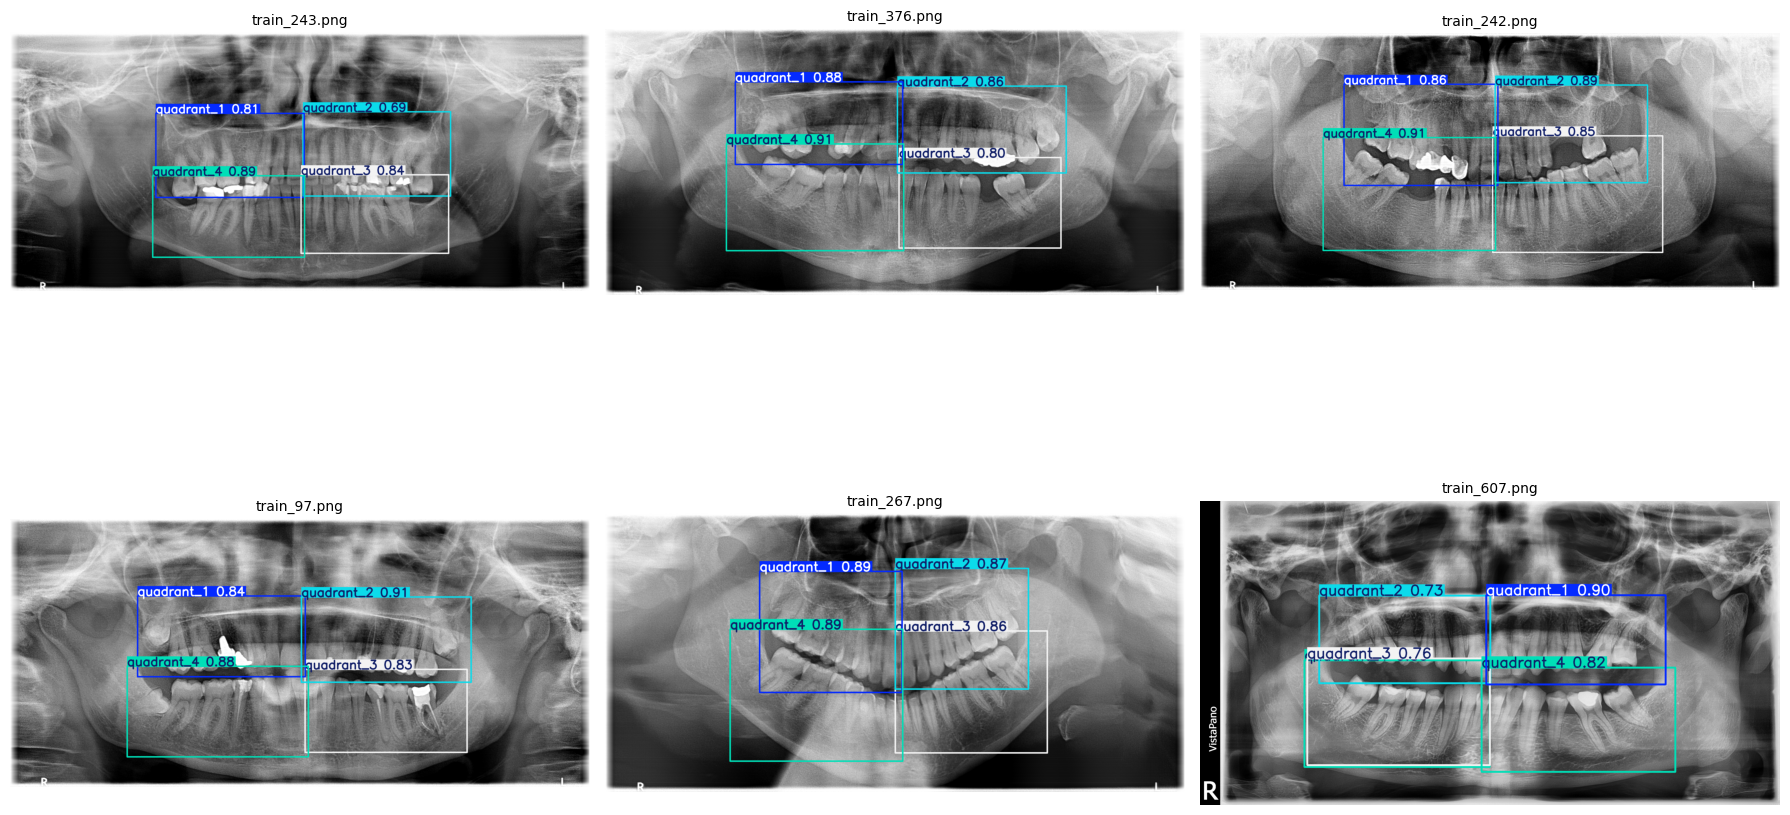


✅ PIPELINE COMPLETE!

📁 Results saved in: dentex_runs/quadrant_yolo8n
🏆 Best model: dentex_runs/quadrant_yolo8n/weights/best.pt

📈 Final Metrics:
   mAP50: 0.9930
   mAP50-95: 0.7221

🎯 Next Steps:
   1. Use this model for hierarchical Stage 2 training
   2. Or proceed with enumeration detection


In [5]:
"""
DENTEX Challenge - Stage 1: Quadrant Detection with YOLOv8
Fixed for actual DENTEX data structure
Optimized for Google Colab T4 GPU
"""

import os
import json
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import yaml

# ============================================================================
# FIXED CONVERSION FOR DENTEX STRUCTURE
# ============================================================================

def convert_dentex_quadrant_to_yolo(data_dir, output_dir):
    """
    Convert DENTEX quadrant annotations to YOLO format
    Handles the specific structure: categories named '1', '2', '3', '4'

    Args:
        data_dir: Path to /content/temp_data/training_data/quadrant
        output_dir: Directory to save YOLO format files
    """
    print("=" * 80)
    print("CONVERTING DENTEX QUADRANT DATA TO YOLO FORMAT")
    print("=" * 80)

    data_path = Path(data_dir)
    annotation_file = data_path / 'train_quadrant.json'
    images_dir = data_path / 'xrays'

    # Verify paths exist
    if not annotation_file.exists():
        raise FileNotFoundError(f"Annotation file not found: {annotation_file}")
    if not images_dir.exists():
        raise FileNotFoundError(f"Images directory not found: {images_dir}")

    print(f"\n📁 Source paths:")
    print(f"   Annotations: {annotation_file}")
    print(f"   Images: {images_dir}")
    print(f"   Found {len(list(images_dir.glob('*.png')))} images")

    # Load annotations
    with open(annotation_file, 'r') as f:
        coco_data = json.load(f)

    print(f"\n📊 Dataset statistics:")
    print(f"   Images: {len(coco_data['images'])}")
    print(f"   Annotations: {len(coco_data['annotations'])}")
    print(f"   Categories: {len(coco_data['categories'])}")

    # Create category mapping
    # Categories are: ID 0->name '2', ID 1->name '1', ID 2->name '3', ID 3->name '4'
    # We need to map to YOLO classes 0-3 where:
    # YOLO class 0 = Quadrant 1 (top right)
    # YOLO class 1 = Quadrant 2 (top left)
    # YOLO class 2 = Quadrant 3 (bottom left)
    # YOLO class 3 = Quadrant 4 (bottom right)

    category_to_yolo = {}
    for cat in coco_data['categories']:
        cat_id = cat['id']
        cat_name = cat['name']  # This is '1', '2', '3', or '4'
        yolo_class = int(cat_name) - 1  # Convert '1' -> 0, '2' -> 1, etc.
        category_to_yolo[cat_id] = yolo_class

    print(f"\n🎯 Category mapping (COCO ID -> YOLO class):")
    for cat in coco_data['categories']:
        coco_id = cat['id']
        yolo_class = category_to_yolo[coco_id]
        print(f"   COCO ID {coco_id} (Quadrant {cat['name']}) -> YOLO class {yolo_class}")

    # Create output directories
    output_path = Path(output_dir)
    labels_dir = output_path / 'labels'
    images_out_dir = output_path / 'images'
    labels_dir.mkdir(parents=True, exist_ok=True)
    images_out_dir.mkdir(parents=True, exist_ok=True)

    # Build image id to filename mapping
    image_info = {img['id']: img for img in coco_data['images']}

    # Group annotations by image
    annotations_by_image = {}
    for anno in coco_data['annotations']:
        img_id = anno['image_id']
        if img_id not in annotations_by_image:
            annotations_by_image[img_id] = []
        annotations_by_image[img_id].append(anno)

    print(f"\n🔄 Converting and copying files...")

    converted_count = 0
    skipped_count = 0

    for img_id, img_data in tqdm(image_info.items(), desc="Processing images"):
        img_filename = img_data['file_name']
        img_width = img_data['width']
        img_height = img_data['height']

        # Source image path
        src_img_path = images_dir / img_filename

        if not src_img_path.exists():
            print(f"⚠️  Image not found: {src_img_path}")
            skipped_count += 1
            continue

        # Copy image to output directory
        dst_img_path = images_out_dir / img_filename
        shutil.copy(src_img_path, dst_img_path)

        # Create YOLO label file
        if img_id not in annotations_by_image:
            skipped_count += 1
            continue

        label_filename = Path(img_filename).stem + '.txt'
        label_path = labels_dir / label_filename

        yolo_annotations = []
        for anno in annotations_by_image[img_id]:
            category_id = anno['category_id']
            yolo_class = category_to_yolo[category_id]

            # Convert bbox from [x, y, width, height] to YOLO format
            bbox = anno['bbox']
            x, y, w, h = bbox

            # YOLO format: normalized [x_center, y_center, width, height]
            x_center = (x + w / 2) / img_width
            y_center = (y + h / 2) / img_height
            norm_width = w / img_width
            norm_height = h / img_height

            # YOLO format line: class x_center y_center width height
            yolo_annotations.append(f"{yolo_class} {x_center:.6f} {y_center:.6f} {norm_width:.6f} {norm_height:.6f}")

        # Save label file
        if yolo_annotations:
            with open(label_path, 'w') as f:
                f.write('\n'.join(yolo_annotations))
            converted_count += 1

    print(f"\n✅ Conversion complete!")
    print(f"   Successfully converted: {converted_count} images")
    print(f"   Skipped: {skipped_count} images")
    print(f"   Images saved to: {images_out_dir}")
    print(f"   Labels saved to: {labels_dir}")

    return converted_count


def split_and_organize_dataset(temp_dir, final_dir, train_ratio=0.85):
    """
    Split converted data into train/val and organize for YOLO

    Args:
        temp_dir: Directory with converted images and labels
        final_dir: Final YOLO dataset directory
        train_ratio: Ratio of training data (default 0.85 = 85% train, 15% val)
    """
    print("\n" + "=" * 80)
    print("SPLITTING AND ORGANIZING DATASET")
    print("=" * 80)

    temp_path = Path(temp_dir)
    images_dir = temp_path / 'images'
    labels_dir = temp_path / 'labels'

    # Get all image files
    image_files = sorted(list(images_dir.glob('*.png')))
    print(f"\n📊 Total images: {len(image_files)}")

    # Shuffle and split
    np.random.seed(42)  # For reproducibility
    indices = np.random.permutation(len(image_files))
    split_idx = int(len(image_files) * train_ratio)

    train_indices = indices[:split_idx]
    val_indices = indices[split_idx:]

    train_images = [image_files[i] for i in train_indices]
    val_images = [image_files[i] for i in val_indices]

    print(f"   Train: {len(train_images)} images ({train_ratio*100:.1f}%)")
    print(f"   Val: {len(val_images)} images ({(1-train_ratio)*100:.1f}%)")

    # Create output structure
    final_path = Path(final_dir)
    for split in ['train', 'val']:
        (final_path / split / 'images').mkdir(parents=True, exist_ok=True)
        (final_path / split / 'labels').mkdir(parents=True, exist_ok=True)

    # Copy files
    def copy_split(image_list, split_name):
        for img_path in tqdm(image_list, desc=f"Copying {split_name} data"):
            # Copy image
            dst_img = final_path / split_name / 'images' / img_path.name
            shutil.copy(img_path, dst_img)

            # Copy label
            label_path = labels_dir / (img_path.stem + '.txt')
            if label_path.exists():
                dst_label = final_path / split_name / 'labels' / label_path.name
                shutil.copy(label_path, dst_label)

    copy_split(train_images, 'train')
    copy_split(val_images, 'val')

    print(f"\n✅ Dataset organized in: {final_dir}")

    # Verify the split
    train_img_count = len(list((final_path / 'train' / 'images').glob('*.png')))
    train_label_count = len(list((final_path / 'train' / 'labels').glob('*.txt')))
    val_img_count = len(list((final_path / 'val' / 'images').glob('*.png')))
    val_label_count = len(list((final_path / 'val' / 'labels').glob('*.txt')))

    print(f"\n✓ Verification:")
    print(f"   Train: {train_img_count} images, {train_label_count} labels")
    print(f"   Val: {val_img_count} images, {val_label_count} labels")


def create_yolo_config(dataset_dir):
    """Create YAML configuration file for YOLO training"""

    config = {
        'path': str(Path(dataset_dir).absolute()),
        'train': 'train/images',
        'val': 'val/images',
        'nc': 4,
        'names': ['quadrant_1', 'quadrant_2', 'quadrant_3', 'quadrant_4']
    }

    config_path = Path(dataset_dir) / 'dentex_quadrant.yaml'
    with open(config_path, 'w') as f:
        yaml.dump(config, f, default_flow_style=False)

    print(f"\n📝 YOLO config created: {config_path}")
    print(f"\nConfig contents:")
    print(yaml.dump(config, default_flow_style=False))

    return str(config_path)


# ============================================================================
# TRAINING WITH YOLOV8
# ============================================================================

def train_yolo_quadrant_detector(config_path, epochs=100, imgsz=640, batch=16):
    """
    Train YOLOv8 model for quadrant detection
    Optimized for T4 GPU with 16GB memory
    """
    print("\n" + "=" * 80)
    print("TRAINING YOLOV8 FOR QUADRANT DETECTION")
    print("=" * 80)

    # Install/import ultralytics
    try:
        from ultralytics import YOLO
    except ImportError:
        print("📦 Installing ultralytics...")
        os.system("pip install ultralytics -q")
        from ultralytics import YOLO

    # Initialize model - use nano for T4 efficiency
    print("\n🚀 Initializing YOLOv8n (nano) model...")
    model = YOLO('yolov8n.pt')

    # Training parameters optimized for T4 and dental X-rays
    train_args = {
        'data': config_path,
        'epochs': epochs,
        'imgsz': imgsz,
        'batch': batch,
        'device': 0,  # Use GPU
        'patience': 20,  # Early stopping patience
        'save': True,
        'save_period': 10,  # Save checkpoint every 10 epochs
        'cache': True,  # Cache images in RAM for faster training
        'workers': 2,  # Reduced workers for Colab
        'project': 'dentex_runs',
        'name': 'quadrant_yolo8n',
        'exist_ok': True,
        'pretrained': True,
        'optimizer': 'SGD',
        'lr0': 0.01,  # Initial learning rate
        'lrf': 0.01,  # Final learning rate
        'momentum': 0.937,
        'weight_decay': 0.0005,
        'warmup_epochs': 3.0,
        'warmup_momentum': 0.8,
        'box': 7.5,  # Box loss gain
        'cls': 0.5,  # Class loss gain
        'dfl': 1.5,  # DFL loss gain

        # Augmentation settings (appropriate for dental X-rays)
        'hsv_h': 0.015,  # Hue augmentation (minimal for X-rays)
        'hsv_s': 0.3,    # Saturation
        'hsv_v': 0.2,    # Value/brightness
        'degrees': 5.0,  # Rotation ±5 degrees (X-ray positioning variation)
        'translate': 0.1,  # Translation
        'scale': 0.2,    # Scaling
        'shear': 0.0,    # No shearing
        'perspective': 0.0,  # No perspective
        'flipud': 0.0,   # No vertical flip (not natural for X-rays)
        'fliplr': 0.5,   # Horizontal flip OK (left-right symmetry)
        'mosaic': 1.0,   # Mosaic augmentation
        'mixup': 0.1,    # Mixup augmentation
        'copy_paste': 0.0,  # No copy-paste for X-rays
    }

    print(f"\n⚙️  Training configuration:")
    print(f"   Model: YOLOv8n")
    print(f"   Epochs: {epochs}")
    print(f"   Image size: {imgsz}")
    print(f"   Batch size: {batch}")
    print(f"   Device: GPU (CUDA:0)")
    print(f"   Cache: {train_args['cache']}")

    # Train
    print(f"\n🎯 Starting training...")
    print(f"   This will take approximately 2-3 hours on T4 GPU")
    print(f"   Progress will be saved every 10 epochs")

    results = model.train(**train_args)

    print("\n✅ Training complete!")
    print(f"   Results directory: {results.save_dir}")
    print(f"   Best model: {results.save_dir}/weights/best.pt")
    print(f"   Last model: {results.save_dir}/weights/last.pt")

    return model, results


# ============================================================================
# EVALUATION AND VISUALIZATION
# ============================================================================

def evaluate_model(model, config_path):
    """Evaluate the trained model on validation set"""
    print("\n" + "=" * 80)
    print("EVALUATING MODEL")
    print("=" * 80)

    metrics = model.val(data=config_path)

    print(f"\n📊 Validation Metrics:")
    print(f"   mAP50: {metrics.box.map50:.4f}")
    print(f"   mAP50-95: {metrics.box.map:.4f}")
    print(f"   Precision: {metrics.box.mp:.4f}")
    print(f"   Recall: {metrics.box.mr:.4f}")

    # Per-class metrics
    print(f"\n📈 Per-class AP50:")
    class_names = ['Q1', 'Q2', 'Q3', 'Q4']
    for i, (name, ap) in enumerate(zip(class_names, metrics.box.ap50)):
        print(f"   {name}: {ap:.4f}")

    return metrics


def visualize_predictions(model, val_images_dir, num_samples=6, save_path='predictions.png'):
    """Visualize model predictions on validation images"""
    print("\n" + "=" * 80)
    print("VISUALIZING PREDICTIONS")
    print("=" * 80)

    val_path = Path(val_images_dir)
    image_files = list(val_path.glob('*.png'))

    if len(image_files) == 0:
        print(f"⚠️  No images found in {val_images_dir}")
        return

    # Randomly sample images
    np.random.seed(42)
    sample_images = np.random.choice(image_files, min(num_samples, len(image_files)), replace=False)

    print(f"🖼️  Visualizing {len(sample_images)} predictions...")

    # Create figure
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    for idx, img_path in enumerate(sample_images):
        # Predict
        results = model(str(img_path), verbose=False)

        # Plot
        img_with_boxes = results[0].plot()
        img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)

        axes[idx].imshow(img_rgb)
        axes[idx].set_title(f"{img_path.name}", fontsize=10)
        axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"✅ Saved visualization to: {save_path}")
    plt.show()


# ============================================================================
# COMPLETE PIPELINE
# ============================================================================

def run_complete_pipeline():
    """
    Complete end-to-end pipeline for quadrant detection
    """
    print("\n" + "=" * 80)
    print("DENTEX QUADRANT DETECTION - COMPLETE PIPELINE")
    print("=" * 80)

    # Paths
    SOURCE_DATA_DIR = "/content/temp_data/training_data/quadrant"
    TEMP_YOLO_DIR = "/content/yolo_temp"
    FINAL_YOLO_DIR = "/content/dentex_quadrant_yolo"

    # Step 1: Convert to YOLO format
    print("\n🔄 STEP 1: Converting COCO to YOLO format...")
    convert_dentex_quadrant_to_yolo(SOURCE_DATA_DIR, TEMP_YOLO_DIR)

    # Step 2: Split and organize dataset
    print("\n📂 STEP 2: Splitting into train/val...")
    split_and_organize_dataset(TEMP_YOLO_DIR, FINAL_YOLO_DIR, train_ratio=0.85)

    # Step 3: Create YOLO config
    print("\n📝 STEP 3: Creating YOLO config...")
    config_path = create_yolo_config(FINAL_YOLO_DIR)

    # Step 4: Train model
    print("\n🎯 STEP 4: Training YOLOv8 model...")
    model, results = train_yolo_quadrant_detector(
        config_path,
        epochs=100,
        imgsz=640,
        batch=16
    )

    # Step 5: Evaluate
    print("\n📊 STEP 5: Evaluating model...")
    metrics = evaluate_model(model, config_path)

    # Step 6: Visualize
    print("\n🖼️  STEP 6: Visualizing predictions...")
    val_img_dir = Path(FINAL_YOLO_DIR) / 'val' / 'images'
    visualize_predictions(model, val_img_dir, num_samples=6)

    print("\n" + "=" * 80)
    print("✅ PIPELINE COMPLETE!")
    print("=" * 80)
    print(f"\n📁 Results saved in: dentex_runs/quadrant_yolo8n")
    print(f"🏆 Best model: dentex_runs/quadrant_yolo8n/weights/best.pt")
    print(f"\n📈 Final Metrics:")
    print(f"   mAP50: {metrics.box.map50:.4f}")
    print(f"   mAP50-95: {metrics.box.map:.4f}")
    print(f"\n🎯 Next Steps:")
    print(f"   1. Use this model for hierarchical Stage 2 training")
    print(f"   2. Or proceed with enumeration detection")
    print("=" * 80)

    return model, metrics


# ============================================================================
# QUICK START - RUN THIS!
# ============================================================================

if __name__ == "__main__":
    # Run the complete pipeline
    model, metrics = run_complete_pipeline()

# v3 final after solving categories key error ,dataset generation , ids error

In [15]:
import os
import json
import cv2
import shutil
import yaml
import numpy as np
from pathlib import Path
from tqdm import tqdm
from ultralytics import YOLO

# ==============================================================================
# 1. ROBUST GENERATION FUNCTION (Fixes KeyError & Adds Padding)
# ==============================================================================
def create_stage2_dataset_robust(json_path, images_dir, stage1_model_path, output_dir, padding_pct=0.1):
    print("="*80)
    print("🚀 GENERATING STAGE 2 DATASET (TEETH ENUMERATION)")
    print("="*80)

    # Setup Output Directory (Wipe and recreate to ensure clean start)
    dest_path = Path(output_dir)
    if dest_path.exists(): shutil.rmtree(dest_path)
    (dest_path / 'images').mkdir(parents=True, exist_ok=True)
    (dest_path / 'labels').mkdir(parents=True, exist_ok=True)

    # Load JSON
    print(f"📂 Loading annotations: {json_path}")
    with open(json_path, 'r') as f:
        coco = json.load(f)

    # HARDCODED FDI MAP (Maps 11-48 -> 0-31)
    # This acts as a fallback if the JSON uses raw FDI numbers.
    fdi_ids = [
        11, 12, 13, 14, 15, 16, 17, 18,
        21, 22, 23, 24, 25, 26, 27, 28,
        31, 32, 33, 34, 35, 36, 37, 38,
        41, 42, 43, 44, 45, 46, 47, 48
    ]
    fdi_map = {code: i for i, code in enumerate(sorted(fdi_ids))}

    # Load Stage 1 Model
    print(f"🤖 Loading Stage 1 Model: {stage1_model_path}")
    if not os.path.exists(stage1_model_path):
        raise FileNotFoundError(f"Stage 1 model not found at {stage1_model_path}")
    model = YOLO(stage1_model_path)

    # Group annotations by image
    img_to_anns = {}
    if 'annotations' in coco:
        for ann in coco['annotations']:
            img_id = ann['image_id']
            if img_id not in img_to_anns: img_to_anns[img_id] = []
            img_to_anns[img_id].append(ann)

    stats = {'images': 0, 'crops': 0, 'teeth': 0}

    # Process Images
    images_list = coco.get('images', [])
    for img_info in tqdm(images_list, desc="Processing X-rays"):
        img_id = img_info['id']
        fname = img_info['file_name']
        src_path = Path(images_dir) / fname

        if not src_path.exists(): continue

        # 1. Inference (Find Quadrants)
        results = model.predict(str(src_path), verbose=False, conf=0.25)

        img = cv2.imread(str(src_path))
        if img is None: continue
        h_img, w_img = img.shape[:2]

        gt_teeth = img_to_anns.get(img_id, [])
        if not gt_teeth: continue

        # 2. Process Quadrants
        for box in results[0].boxes:
            coords = box.xyxy[0].cpu().numpy()
            q_cls = int(box.cls[0].item()) + 1

            qx1, qy1, qx2, qy2 = coords
            qw, qh = qx2 - qx1, qy2 - qy1

            # Apply Padding
            pad_x = int(qw * padding_pct)
            pad_y = int(qh * padding_pct)

            crop_x1 = max(0, int(qx1 - pad_x))
            crop_y1 = max(0, int(qy1 - pad_y))
            crop_x2 = min(w_img, int(qx2 + pad_x))
            crop_y2 = min(h_img, int(qy2 + pad_y))

            crop_w = crop_x2 - crop_x1
            crop_h = crop_y2 - crop_y1

            if crop_w < 50 or crop_h < 50: continue

            # 3. Map Teeth
            label_lines = []
            for tooth in gt_teeth:
                if 'bbox' not in tooth: continue
                tx, ty, tw, th = tooth['bbox']

                tx_center = tx + tw/2
                ty_center = ty + th/2

                # Check if tooth center is inside crop
                if (crop_x1 < tx_center < crop_x2) and (crop_y1 < ty_center < crop_y2):
                    new_cx = (tx_center - crop_x1) / crop_w
                    new_cy = (ty_center - crop_y1) / crop_h
                    new_w = tw / crop_w
                    new_h = th / crop_h

                    # --- HYBRID CLASS LOGIC ---
                    # Check 'category_id_1' first (based on your inspection), then 'category_id'
                    raw_id = tooth.get('category_id_1', tooth.get('category_id'))
                    final_cls = -1

                    if raw_id in fdi_map:
                        final_cls = fdi_map[raw_id] # It's an FDI number (e.g. 11), map to 0
                    elif 0 <= raw_id <= 31:
                        final_cls = raw_id        # It's already an index (e.g. 0), keep it

                    if final_cls != -1 and 0 < new_cx < 1 and 0 < new_cy < 1:
                        label_lines.append(f"{final_cls} {new_cx:.6f} {new_cy:.6f} {new_w:.6f} {new_h:.6f}")
                        stats['teeth'] += 1

            if label_lines:
                crop_name = f"{Path(fname).stem}_q{q_cls}"
                # Saving as JPG to save space/speed
                cv2.imwrite(str(dest_path / 'images' / f"{crop_name}.jpg"), img[crop_y1:crop_y2, crop_x1:crop_x2])
                with open(dest_path / 'labels' / f"{crop_name}.txt", 'w') as f:
                    f.write('\n'.join(label_lines))
                stats['crops'] += 1

        stats['images'] += 1

    print(f"\n✅ Generation Complete! Created {stats['crops']} crops.")
    return stats['crops'] > 0

# ==============================================================================
# 2. UPDATED SPLITTER (Handles JPGs)
# ==============================================================================
def split_dataset_robust(base_dir, train_ratio=0.85):
    print("\n📦 Organizing Dataset (Handling JPG/PNG)...")
    base = Path(base_dir)
    images_dir = base / 'images'
    labels_dir = base / 'labels'

    # Find all images (jpg or png)
    all_images = list(images_dir.glob('*.png')) + list(images_dir.glob('*.jpg'))
    all_images = sorted(all_images)

    if len(all_images) == 0:
        raise FileNotFoundError(f"❌ No images found in {images_dir}. Generation likely failed.")

    print(f"   Found {len(all_images)} images to split.")

    # Shuffle
    np.random.seed(42)
    indices = np.random.permutation(len(all_images))
    split_idx = int(len(all_images) * train_ratio)

    # Create structure
    for split in ['train', 'val']:
        (base / split / 'images').mkdir(parents=True, exist_ok=True)
        (base / split / 'labels').mkdir(parents=True, exist_ok=True)

    # Move files
    for i, idx in enumerate(tqdm(indices, desc="Moving files")):
        split = 'train' if i < split_idx else 'val'
        img_path = all_images[idx]

        # Move Image
        shutil.move(str(img_path), str(base / split / 'images' / img_path.name))

        # Move Label
        label_name = img_path.stem + '.txt'
        label_src = labels_dir / label_name
        if label_src.exists():
            shutil.move(str(label_src), str(base / split / 'labels' / label_name))

    print("✅ Dataset Split Complete.")

In [14]:
# ==============================================================================
# 3. EXECUTION BLOCK
# ==============================================================================

# PATHS (Using the paths you confirmed worked for extraction)
JSON_FILE = "/content/temp_data/training_data/quadrant_enumeration/train_quadrant_enumeration.json"
# Note: Ensure this points to where the actual PNG X-rays are
IMAGES_DIR = "/content/temp_data/training_data/quadrant_enumeration/xrays"
# Stage 1 Model Path
STAGE1_MODEL = "dentex_runs/quadrant_yolo8n/weights/best.pt"
OUTPUT_DIR = "/content/dentex_stage2_yolo"

# A. Generate Data
success = create_stage2_dataset_robust(JSON_FILE, IMAGES_DIR, STAGE1_MODEL, OUTPUT_DIR)

if success:
    # B. Split Data
    split_dataset_robust(OUTPUT_DIR)



🚀 GENERATING STAGE 2 DATASET (TEETH ENUMERATION)
📂 Loading annotations: /content/temp_data/training_data/quadrant_enumeration/train_quadrant_enumeration.json
🤖 Loading Stage 1 Model: dentex_runs/quadrant_yolo8n/weights/best.pt


Processing X-rays: 100%|██████████| 634/634 [01:55<00:00,  5.50it/s]



✅ Generation Complete! Created 2580 crops.

📦 Organizing Dataset (Handling JPG/PNG)...
   Found 2508 images to split.


Moving files: 100%|██████████| 2508/2508 [00:00<00:00, 10433.72it/s]

✅ Dataset Split Complete.


In [18]:
# C. Create Config
print("\n📝 Creating Config...")
config = {
    'path': str(Path(OUTPUT_DIR).absolute()),
    'train': 'train/images',
    'val': 'val/images',
    'nc': 32,
    'names': [str(i) for i in range(32)] # 0-31
}
config_path = Path(OUTPUT_DIR) / 'dentex_stage2.yaml'
with open(config_path, 'w') as f:
    yaml.dump(config, f)

# D. Train
print("\n🚀 Starting Stage 2 Training...")
model = YOLO('yolov8s.pt')
model.train(
    data=str(config_path),
    epochs=50,
    imgsz=640,
    batch=16,
    project='dentex_runs',
    name='enumeration_stage2',
    fliplr=0.0 # CRITICAL: Do not flip teeth horizontally
)


📝 Creating Config...

🚀 Starting Stage 2 Training...
Ultralytics 8.3.242 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dentex_stage2_yolo/dentex_stage2.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=enumeration_stage22, nbs=64, nms=False, opset=None, optimize=False, o

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78600582a240>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

# inference demo stage1 + stage2

🖼️ Processing: train_896.png


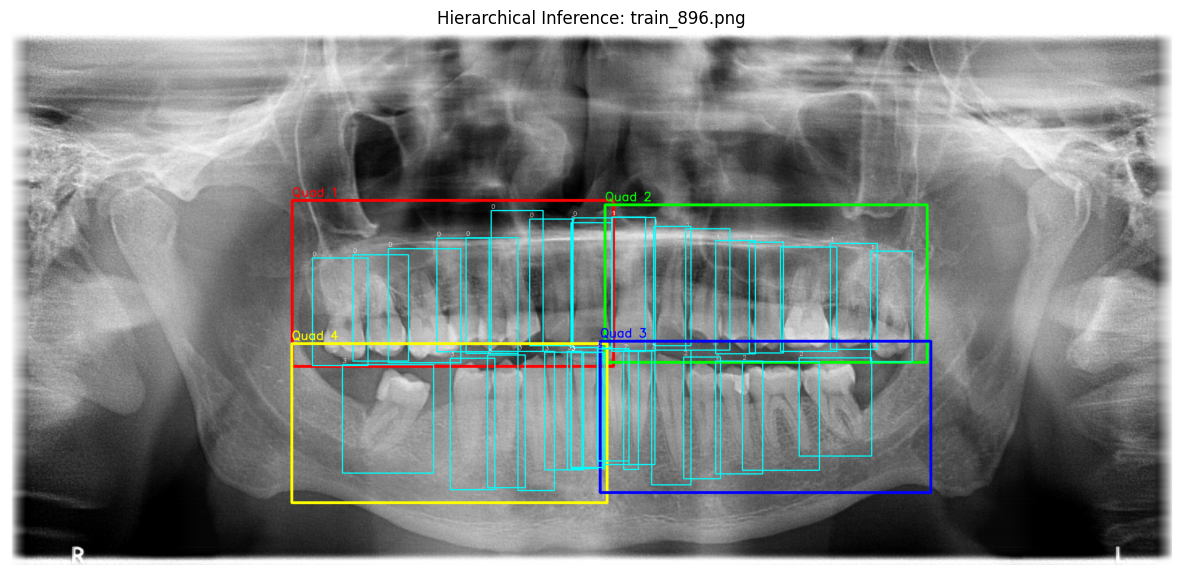

In [23]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from ultralytics import YOLO
import random

def visualize_hierarchical_inference(image_path, stage1_path, stage2_path):
    print(f"🖼️ Processing: {Path(image_path).name}")

    # 1. Load Models
    model_s1 = YOLO(stage1_path)
    model_s2 = YOLO(stage2_path)

    # 2. Load Image
    img = cv2.imread(image_path)
    if img is None:
        print("❌ Error: Could not load image.")
        return
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h_img, w_img = img.shape[:2]

    # Create a copy to draw on
    canvas = img_rgb.copy()

    # 3. RUN STAGE 1: Detect Quadrants
    results_s1 = model_s1.predict(img, verbose=False, conf=0.5)

    # Colors for visualization
    quad_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)] # RGB

    for box in results_s1[0].boxes:
        # Get Quadrant Box
        coords = box.xyxy[0].cpu().numpy()
        q_cls = int(box.cls[0].item()) # 0-3 (Q1-Q4)

        qx1, qy1, qx2, qy2 = map(int, coords)

        # Draw Quadrant Box (Thick Line)
        cv2.rectangle(canvas, (qx1, qy1), (qx2, qy2), quad_colors[q_cls], 5)
        cv2.putText(canvas, f"Quad {q_cls+1}", (qx1, qy1-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, quad_colors[q_cls], 2)

        # 4. PREPARE CROP (With Padding logic used in training)
        qw, qh = qx2 - qx1, qy2 - qy1
        pad_x = int(qw * 0.1)
        pad_y = int(qh * 0.1)

        crop_x1 = max(0, qx1 - pad_x)
        crop_y1 = max(0, qy1 - pad_y)
        crop_x2 = min(w_img, qx2 + pad_x)
        crop_y2 = min(h_img, qy2 + pad_y)

        crop_img = img[crop_y1:crop_y2, crop_x1:crop_x2]
        if crop_img.size == 0: continue

        # 5. RUN STAGE 2: Detect Teeth inside Crop
        results_s2 = model_s2.predict(crop_img, verbose=False, conf=0.25)

        for t_box in results_s2[0].boxes:
            # Get Tooth Coords (Relative to Crop)
            t_coords = t_box.xyxy[0].cpu().numpy()
            t_cls = int(t_box.cls[0].item()) # 0-31

            tx1, ty1, tx2, ty2 = t_coords

            # Map back to Global Coordinates
            global_x1 = int(tx1 + crop_x1)
            global_y1 = int(ty1 + crop_y1)
            global_x2 = int(tx2 + crop_x1)
            global_y2 = int(ty2 + crop_y1)

            # Draw Tooth Box (Thin Line)
            # Tooth color: Cyan
            cv2.rectangle(canvas, (global_x1, global_y1), (global_x2, global_y2), (0, 255, 255), 2)

            # Draw Label (Small text)
            # Map 0-31 back to FDI (11-48) for display if needed
            # For now, just show the class ID
            cv2.putText(canvas, str(t_cls), (global_x1, global_y1-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    # 6. Show Result
    plt.figure(figsize=(15, 10))
    plt.imshow(canvas)
    plt.axis('off')
    plt.title(f"Hierarchical Inference: {Path(image_path).name}")
    plt.show()

# ==========================================
# EXECUTE VISUALIZATION
# ==========================================

#/content/temp_data/training_data/quadrant_enumeration/xrays

# 1. Define Paths
# Pick a random image from your ORIGINAL quadrant training/val set
source_images_dir = Path("/content/temp_data/training_data/unlabelled/xrays")
all_images = list(source_images_dir.glob("*.png"))

if len(all_images) > 0:
    test_image = random.choice(all_images)

    # 2. Define Model Paths
    stage1_model = "/content/dentex_runs/quadrant_yolo8n/weights/best.pt"
    # Note: Use 'enumeration_stage2_final' if you ran the final corrected script
    stage2_model = "/content/dentex_runs/enumeration_stage22/weights/best.pt"

    if Path(stage1_model).exists() and Path(stage2_model).exists():
        visualize_hierarchical_inference(test_image, stage1_model, stage2_model)
    else:
        print("❌ Error: Could not find model weights. Check your paths.")
else:
    print("❌ Error: No source images found to test.")